In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d deeprodge/indian-food-images-12-different-dishes

 97% 422M/435M [00:04<00:00, 139MB/s]
100% 435M/435M [00:04<00:00, 91.9MB/s]


In [ ]:
!unzip /content/indian-food-images-12-different-dishes.zip

Archive:  /content/food20dataset.zip
  inflating: food20dataset/test_set/biriyani/biriyanitest (1).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (10).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (11).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (12).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (13).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (14).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (15).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (16).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (17).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (18).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (19).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (2).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (20).jpg  
  inflating: food20dataset/test_set/biriyani/biriyanitest (21).jpg  

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from skimage import transform
from tqdm import tqdm
import gc
import os
import cv2


In [ ]:
#Loading the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 20
img_width, img_height = 225, 225

#Train data path
train_data_dir ='/content/Indian Cuisine/train'#../input/indian-food-images-12-different-dishes/Indian Cuisine/train'

#Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',shuffle=False)

#Validation data path
val_data_dir ='/content/Indian Cuisine/val'

#Normalizing data
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',shuffle=False)

# Test data path
test_data_dir = '/content/Indian Cuisine/test'

#Data augmentation
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',shuffle=False)


Found 1400 images belonging to 20 classes.
Found 600 images belonging to 20 classes.


In [ ]:
class_map = train_generator.class_indices
class_map

{'biriyani': 0,
 'bisibelebath': 1,
 'butternaan': 2,
 'chaat': 3,
 'chappati': 4,
 'dhokla': 5,
 'dosa': 6,
 'gulab jamun': 7,
 'halwa': 8,
 'idly': 9,
 'kathi roll': 10,
 'meduvadai': 11,
 'noodles': 12,
 'paniyaram': 13,
 'poori': 14,
 'samosa': 15,
 'tandoori chicken': 16,
 'upma': 17,
 'vada pav': 18,
 'ven pongal': 19}

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Input

#Importing the InceptionV3 model with the pretrained imagenet weights
Inception = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_width, img_height, 3)))

#Setting the initial layers of model as non trainable
for layer in Inception.layers:
    layer.trainable = False
    
#Adding the final dense layers and global average pooling layer to the pretrained model
modelHead = Inception.output
modelHead = GlobalAveragePooling2D()(modelHead)
modelHead = Flatten(name="flatten")(modelHead)
modelHead = Dense(128, activation="relu")(modelHead)
modelHead = Dense(12, activation="softmax")(modelHead)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.models import Model

#The final model with all the layers
model = Model(inputs=Inception.input, outputs=modelHead)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

num_epochs = 20

#Compiling the model
opt = Adam(learning_rate = 1e-4)
#opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss = "categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
historyModel = model.fit_generator(train_generator, 
              validation_data = val_generator, 
              epochs = num_epochs,
              verbose = 1)

<ipython-input-16-001015d2c241>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyModel = model.fit_generator(train_generator,


Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
model.save('model_v1_inceptionV3.h5')

In [ ]:
y_pred1 = model.predict_generator(test_generator)
Y_pred_classes1 = np.argmax(y_pred1,axis=1) 
Y_True = test_generator.classes

<ipython-input-17-dcdaed1144f7>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred1 = model.predict_generator(test_generator)


In [ ]:
import seaborn as sn
def plot_confusion_matrix(cm):

    #Setting the figure size
    fig, ax = plt.subplots(figsize=(12,5))
    
    #Creating the pandas dataframe
    d_cm = pd.DataFrame(cm)
    
    sn.set(font_scale=1)
    
    #Setting the fontsize and plotting the heatmap
    sn.heatmap(d_cm, annot=True, fmt='g',annot_kws={"size": 16})
    
    plt.title('Confusion matrix')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label');

    plt.show()
    
def acc_versus_epochs(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,2)
    loss_train = hist.history['accuracy']
    loss_val = hist.history['val_accuracy']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    loss_train = hist.history['loss']
    loss_val = hist.history['val_loss']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

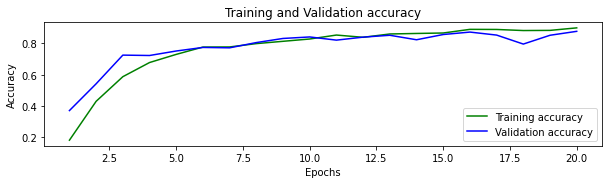

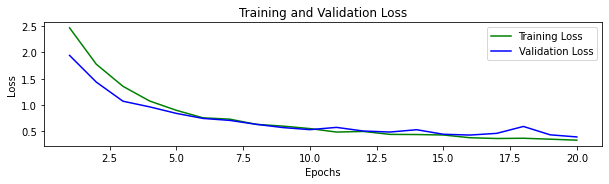

In [ ]:
acc_versus_epochs(historyModel)

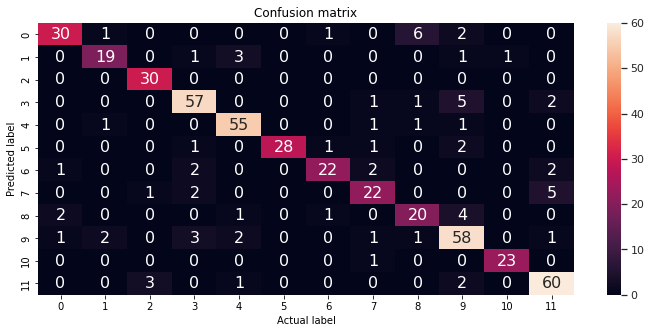

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
plot_confusion_matrix(confusion_matrix(Y_True,Y_pred_classes1))

In [ ]:
from sklearn.metrics import recall_score,precision_score,f1_score

print("Accuracy of Inception : " , recall_score(Y_True, Y_pred_classes1, average='weighted'))

print("Precision score of Inception " , precision_score(Y_True, Y_pred_classes1, average='weighted'))

print("F1 score of Inception : " , f1_score(Y_True, Y_pred_classes1, average='weighted'))

Accuracy of Inception :  0.8697394789579158
Precision score of Inception  0.8852396674192208
F1 score of Inception :  0.8701512486441781


In [ ]:
#Loading the trained inception model
from keras.models import load_model
path_to_model='/content/model_v1_inceptionV3.h5'
model = load_model(path_to_model)

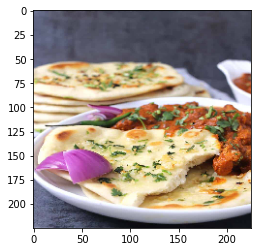

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

import numpy as np
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from keras.applications import vgg16
import matplotlib.pyplot as plt
from pathlib import Path
path = Path("/content/testing/image_0.jpg")
#Load the image
img = load_img(path, target_size=(225,225))
image_array = img_to_array(img)
image_array=image_array/255
plt.imshow(image_array)

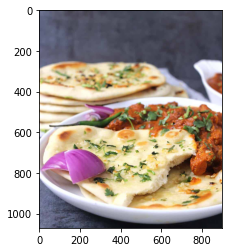

In [ ]:
x_train = np.expand_dims(image_array, axis=0)
#Normalize the data
x_train = vgg16.preprocess_input(x_train)
data = plt.imread(path)
plt.imshow(data)
plt.show()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
test_image=[]
img = tf.keras.utils.load_img('/content/testing/image_0.jpg',target_size=(225,225))
img = tf.keras.utils.img_to_array(img)
img = img/255
# test_image.append(img)
test = np.expand_dims(img,axis=0)

In [ ]:
test.shape

(1, 225, 225, 3)

In [ ]:
recipe=['Biryani', 'Butter Naan', 'Chai', 'Chole Bhature', 'Dhokla', 'Gulab Jamun', 'Jalebi', 'Momos', 'Paneer Sabzi', 'Pav Bhaji', 'Rasgulla', 'Samosa']

In [ ]:
t=model.predict_generator(test)

<ipython-input-75-24396ea2d452>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  t=model.predict_generator(test)


In [ ]:
Y_pred_classes1 = np.argmax(t,axis=1) 

In [ ]:
recipe[Y_pred_classes1[0]]

'Butter Naan'